In [1]:
using StaticArrays, DifferentialEquations, DynamicalSystems, CairoMakie, JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, chem_link, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - chem_link * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - chem_link * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function output(idx, parameter, u0)
    println("index: $idx; chemical_link: $parameter");flush(stdout)
    println("u0: $u0");flush(stdout)
end
function output(Λ, u0)
    println("Λ: $Λ");flush(stdout)
    println("last point: $u0");flush(stdout)
end
function separate()
    println("----------------");flush(stdout)
    println("  ");flush(stdout)
end

separate (generic function with 1 method)

In [4]:
a = 1.; b = 3.; c = 1.; d = 5.;
xr = -1.6; r = 0.01; s = 5.; I = 4.; xv = 2.;
electrical_link = 0.01

0.01

In [5]:
tf = 20000.0
tt = 20000.0
tstep = 0.01
integ_setting = (alg = Vern9(), adaptive = false, dt = 0.01);

In [15]:
# chemical link
start_p = 0.025
finish_p = 0.00
p_range = range(start_p, finish_p, length = 5000);

In [16]:
Λs =  zeros(length(p_range), 6)
u0s = zeros(length(p_range), 6);

In [17]:
for (idx, chemical) in enumerate(p_range)

    if idx == 1
        global u0 = SA[-2.5, 0.0, 0.0, -1.5, 0.0, 0.0]
    end

    output(idx, chemical, u0)

    p = SA[a, b, c, d, s, xr, r, I, xv, chemical, electrical_link]
    ds = ContinuousDynamicalSystem(HR,  u0, p)

    tr = trajectory(ds, 500.0, Δt = tstep; Ttr = tt, diffeq = integ_setting)
    u0 = tr[end]; ds = ContinuousDynamicalSystem(HR,  u0, p)
    Λ = lyapunovspectrum(ds, tf; diffeq = integ_setting)
    Λs[idx, :] = Λ
    u0s[idx, :] = u0
    
    output(Λs[idx, :], u0s[idx, :])
    separate()
    
end

index: 1; chemical_link: 0.025
u0: [-2.5, 0.0, 0.0, -1.5, 0.0, 0.0]
Λ: [0.010120495810844959, 0.002759466794143177, -0.00022852160567442782, -0.0061383864501683965, -7.320776127329135, -10.102828054061055]
last point: [-0.8930036895386229, -3.263714574098742, 3.8088651636097333, -0.6647163758604493, -1.6141697419926895, 3.93188210711655]
----------------
  
index: 2; chemical_link: 0.02499499899979996
u0: [-0.8930036895386229, -3.263714574098742, 3.8088651636097333, -0.6647163758604493, -1.6141697419926895, 3.93188210711655]
Λ: [0.00818550545265421, 0.001569447871976785, -0.000465464084206118, -0.0067816985689131614, -7.360085768003688, -10.087198634646615]
last point: [-0.9072916761268073, -3.226648983822533, 4.064238519217364, 0.8796939269264739, 0.06473055662148183, 3.9491132659537715]
----------------
  
index: 3; chemical_link: 0.02498999799959992
u0: [-0.9072916761268073, -3.226648983822533, 4.064238519217364, 0.8796939269264739, 0.06473055662148183, 3.9491132659537715]
Λ: [0.007

u0: [-0.9228788027777391, -3.3127487924744745, 4.019184431372273, -1.1183166417471846, -5.08707160645319, 4.079811968293433]
Λ: [0.008316927808978794, 0.001243299888253771, -0.00022442271288132927, -0.008807424880107478, -7.3836443007616746, -10.083671303959306]
last point: [-1.1958575422322266, -6.273665445310449, 3.7141691846846214, -1.2464067305287612, -6.785718195018355, 3.8086687374262564]
----------------
  
index: 20; chemical_link: 0.02490498099619924
u0: [-1.1958575422322266, -6.273665445310449, 3.7141691846846214, -1.2464067305287612, -6.785718195018355, 3.8086687374262564]
Λ: [0.007986719818274823, 0.0010908403283142565, -0.0009499263021433989, -0.00833857893500971, -7.3911749596658165, -10.083457232115588]
last point: [-1.1539342753111381, -5.524179927057315, 4.017703233589691, -1.159742878578437, -5.606110978596372, 3.9981121817758716]
----------------
  
index: 21; chemical_link: 0.0248999799959992
u0: [-1.1539342753111381, -5.524179927057315, 4.017703233589691, -1.159742

----------------
  
index: 37; chemical_link: 0.02481996399279856
u0: [-0.9792931867305903, -3.615327859866912, 4.219105003730135, -1.0799254908533489, -4.621411627710022, 4.157324682971043]
Λ: [0.009413193711907722, 0.0018786814075843021, 3.695399817996347e-5, -0.006214323137640523, -7.39360595047533, -10.033639550074183]
last point: [-1.269584303448677, -7.074352485494389, 3.805022192488163, -1.2422308103109494, -6.650534030413013, 3.8993072787057677]
----------------
  
index: 38; chemical_link: 0.02481496299259852
u0: [-1.269584303448677, -7.074352485494389, 3.805022192488163, -1.2422308103109494, -6.650534030413013, 3.8993072787057677]
Λ: [0.008703901755892718, 0.0014816595307000798, -0.00032364381266949293, -0.0067177912026644545, -7.309164739555987, -10.121346542175894]
last point: [-0.6949186314115631, -2.108820534683043, 3.6353900541126545, 0.328439616897143, 0.47418425768859224, 3.722306666587794]
----------------
  
index: 39; chemical_link: 0.02480996199239848
u0: [-0.69491

last point: [0.09292720436084577, -5.064566006070123, 3.8803883930417693, -0.8498419216905732, -2.826283459727395, 4.0098357353700536]
----------------
  
index: 55; chemical_link: 0.024729945989197838
u0: [0.09292720436084577, -5.064566006070123, 3.8803883930417693, -0.8498419216905732, -2.826283459727395, 4.0098357353700536]
Λ: [0.008604548806985662, 0.00043913560650410736, -0.0006044215563684915, -0.008382078359456438, -7.358357915570565, -10.108272335197004]
last point: [-0.0797940191692991, 0.3246777370526635, 3.91579198970373, -0.8976027751902118, -3.3234069737633094, 3.842938520392929]
----------------
  
index: 56; chemical_link: 0.0247249449889978
u0: [-0.0797940191692991, 0.3246777370526635, 3.91579198970373, -0.8976027751902118, -3.3234069737633094, 3.842938520392929]
Λ: [0.006386165148049056, 0.00041753339103327, -0.0016748512048459642, -0.007090673571640925, -7.378156593925482, -10.128404837354285]
last point: [-0.4758058428936697, -0.7797210669782891, 3.845898743456127, -

last point: [-0.8132197050811444, -2.7379358575837727, 3.718770227794208, -1.2722088691586215, -7.145492245171003, 3.7681615081754347]
----------------
  
index: 73; chemical_link: 0.02463992798559712
u0: [-0.8132197050811444, -2.7379358575837727, 3.718770227794208, -1.2722088691586215, -7.145492245171003, 3.7681615081754347]
Λ: [0.009264728760842897, 0.0012288602970691401, -0.0005489175188899269, -0.0056034531586085295, -7.405335434243527, -10.065786670214766]
last point: [-1.166164046933019, -5.654029181180888, 4.023114760216991, -1.1830351311930776, -5.870702210625222, 3.993612823398745]
----------------
  
index: 74; chemical_link: 0.024634926985397078
u0: [-1.166164046933019, -5.654029181180888, 4.023114760216991, -1.1830351311930776, -5.870702210625222, 3.993612823398745]
Λ: [0.00849576344114646, 0.0023210880163882434, -0.0005524622379443701, -0.00796288367653178, -7.416807328627108, -10.026367888873237]
last point: [-1.108688524567746, -5.40550943941383, 3.62076097981878, -0.933

last point: [1.1410388201166233, -0.4800077041076674, 3.939393520270754, -0.917416390862615, -3.6889573016953587, 3.6398988794910516]
----------------
  
index: 91; chemical_link: 0.0245499099819964
u0: [1.1410388201166233, -0.4800077041076674, 3.939393520270754, -0.917416390862615, -3.6889573016953587, 3.6398988794910516]
Λ: [0.007589764866948587, 0.0020730959045586307, -0.0015950572871768804, -0.008096258048823012, -7.401864538721264, -10.05984066780665]
last point: [-1.0881447990581292, -4.772058449162694, 4.083385506762974, -0.9383951605119684, -3.2356647201643116, 4.249935222738059]
----------------
  
index: 92; chemical_link: 0.02454490898179636
u0: [-1.0881447990581292, -4.772058449162694, 4.083385506762974, -0.9383951605119684, -3.2356647201643116, 4.249935222738059]
Λ: [0.00922928296566202, 0.0010576649665089712, -0.0001759194448358131, -0.006688025926877851, -7.309930061841572, -10.128013859745938]
last point: [-1.2401068303765004, -6.743902280403663, 3.770774119024868, -1.2

last point: [0.39382056641867025, 0.46612691243652377, 3.7195391982909087, -1.2381583112719905, -6.8943314639710165, 3.6769411889754715]
----------------
  
index: 109; chemical_link: 0.024459891978395678
u0: [0.39382056641867025, 0.46612691243652377, 3.7195391982909087, -1.2381583112719905, -6.8943314639710165, 3.6769411889754715]
Λ: [0.009618235952480953, 0.002275038600075463, -0.00011302663913359164, -0.0060633879926123525, -7.3622305092922, -10.046608704087348]
last point: [-1.1174281646407735, -5.158064618955227, 3.989174425639177, -1.1892040824578434, -5.9273881482495865, 4.008757321116752]
----------------
  
index: 110; chemical_link: 0.02445489097819564
u0: [-1.1174281646407735, -5.158064618955227, 3.989174425639177, -1.1892040824578434, -5.9273881482495865, 4.008757321116752]
Λ: [0.009195034362339859, 0.0021457597800614322, -0.000737720124385017, -0.00716341974688237, -7.451467887781185, -9.975604037256472]
last point: [-0.8461496280626395, -3.0649032430031373, 3.626575662558

Λ: [0.007580299373486046, 0.0006759755052497108, -0.00022756924857724378, -0.007859981994742613, -7.487968155158353, -10.00995046566142]
last point: [-1.167022469054756, -5.6583747718395605, 4.02936273572254, -1.125620185980687, -5.1858490657516985, 4.053623673757998]
----------------
  
index: 127; chemical_link: 0.02436987397479496
u0: [-1.167022469054756, -5.6583747718395605, 4.02936273572254, -1.125620185980687, -5.1858490657516985, 4.053623673757998]
Λ: [0.006036229398690658, 0.00022385841979727882, -0.0022888073447615977, -0.009004230983147598, -7.413242014015258, -10.106928007072623]
last point: [-1.1852438922966109, -6.036415230562158, 3.928854245905898, 0.15567947836222296, 0.6735078023330114, 4.150479511717741]
----------------
  
index: 128; chemical_link: 0.024364872974594918
u0: [-1.1852438922966109, -6.036415230562158, 3.928854245905898, 0.15567947836222296, 0.6735078023330114, 4.150479511717741]
Λ: [0.00723254276495074, 0.0004812956400788124, -0.0012348808415042962, -0.0

u0: [-1.2234732724599646, -6.57803448061313, 3.7355980964520703, -1.1338864753229778, -5.635526804903912, 3.658106200984455]
Λ: [0.008418298839368989, 0.0007361191150154634, -0.0006229279270083701, -0.0063351782524945855, -7.319311523523423, -10.141619393206696]
last point: [-0.9602018107453121, -3.442025689479075, 4.227629363246654, -0.9629491949822511, -3.938376088747491, 3.701271039889304]
----------------
  
index: 145; chemical_link: 0.02427985597119424
u0: [-0.9602018107453121, -3.442025689479075, 4.227629363246654, -0.9629491949822511, -3.938376088747491, 3.701271039889304]
Λ: [0.00784576126378546, 0.0007239062038562097, -8.285552614676996e-5, -0.007527730986349019, -7.42614321926735, -10.035290593697152]
last point: [-1.0119880147200435, -3.946925736189183, 4.180178685764405, -0.9475686468248647, -3.3068225601365118, 4.2575523127258315]
----------------
  
index: 146; chemical_link: 0.0242748549709942
u0: [-1.0119880147200435, -3.946925736189183, 4.180178685764405, -0.947568646

----------------
  
index: 162; chemical_link: 0.02419483896779356
u0: [-0.6138641254168767, -4.384260311664761, 3.813903339736657, 1.6681524535493346, -5.417433689454518, 3.8104067947251554]
Λ: [0.006092308492393555, 0.0006374678544892371, -0.002268042052732715, -0.00848923991409981, -7.474505451618903, -10.0323278000213]
last point: [-0.863693895803125, -3.160005412245695, 3.663465269413429, -1.1007400443425501, -5.3350791263193384, 3.608211598653541]
----------------
  
index: 163; chemical_link: 0.024189837967593518
u0: [-0.863693895803125, -3.160005412245695, 3.663465269413429, -1.1007400443425501, -5.3350791263193384, 3.608211598653541]
Λ: [0.005025924379010176, -0.0001267273583074769, -0.002459740670940982, -0.008383513119212085, -7.4510673653164465, -10.087604748852103]
last point: [-1.251566251893715, -6.795953713469917, 3.86528895002905, -1.2349822624666493, -6.698901532831352, 3.7525021979104816]
----------------
  
index: 164; chemical_link: 0.02418483696739348
u0: [-1.2515

last point: [-1.2038605994436844, -6.347969591603153, 3.7351326791381743, -1.1374380335206815, -5.680162617986103, 3.6513203698410712]
----------------
  
index: 180; chemical_link: 0.02410482096419284
u0: [-1.2038605994436844, -6.347969591603153, 3.7351326791381743, -1.1374380335206815, -5.680162617986103, 3.6513203698410712]
Λ: [0.008371233615516116, 0.0012263473802116849, -0.001306815069506809, -0.00643040912090292, -7.365611150793376, -10.095984032355393]
last point: [-0.7150409511880209, -2.0754976684444064, 3.8233513062532043, 1.295790552624262, -0.9462368352276546, 3.9854074414859606]
----------------
  
index: 181; chemical_link: 0.0240998199639928
u0: [-0.7150409511880209, -2.0754976684444064, 3.8233513062532043, 1.295790552624262, -0.9462368352276546, 3.9854074414859606]
Λ: [0.007836326276940024, 0.0002777391109904067, -0.0005075427221778089, -0.006475907111885411, -7.3224311368800015, -10.121105194879952]
last point: [-0.7947632726218535, -2.7443800939298777, 3.5667190154219

Λ: [0.009192023714449977, 0.0018761551580344059, 0.00011162729164904084, -0.005576751730744366, -7.362017399690825, -10.051240057488375]
last point: [-0.9502949771747676, -3.8090826117581416, 3.722356987961856, -1.063623158141799, -4.905485198209652, 3.6667461703808746]
----------------
  
index: 198; chemical_link: 0.024014802960592118
u0: [-0.9502949771747676, -3.8090826117581416, 3.722356987961856, -1.063623158141799, -4.905485198209652, 3.6667461703808746]
Λ: [0.009400790944449877, 0.0038240388651732088, -0.001355323199853924, -0.00593645218275065, -7.367146101719022, -10.061609252213321]
last point: [-0.8927718383745987, -3.078965606858616, 4.014626020355438, -0.6616141941734343, -1.5166865627068764, 4.0260179756558]
----------------
  
index: 199; chemical_link: 0.02400980196039208
u0: [-0.8927718383745987, -3.078965606858616, 4.014626020355438, -0.6616141941734343, -1.5166865627068764, 4.0260179756558]
Λ: [0.008311144208233038, 0.0008646072196216178, -0.0010705907719407816, -0.0

u0: [-0.7809370998333384, -2.4034002188883, 3.8660306143233987, -0.3743826645759138, -0.5629291018738269, 3.6527080215228636]
Λ: [0.007468683872026372, 0.0018777778876308245, -0.0021756710592942268, -0.008347422913032204, -7.52126398074411, -9.973004601313814]
last point: [-0.9346013802122661, -3.2501048189843114, 4.21208600093602, -0.7882469563117431, -3.0191511885870614, 4.263327673538892]
----------------
  
index: 216; chemical_link: 0.023924784956991397
u0: [-0.9346013802122661, -3.2501048189843114, 4.21208600093602, -0.7882469563117431, -3.0191511885870614, 4.263327673538892]
Λ: [0.009025307681140718, 0.0017907879470845083, 4.043608203746685e-6, -0.006748515153736689, -7.4003090667879174, -10.044450503360483]
last point: [-1.1730343310630154, -6.028346517172735, 3.6984534140066243, -1.2588117757819481, -6.884180046854837, 3.8667466825770056]
----------------
  
index: 217; chemical_link: 0.023919783956791358
u0: [-1.1730343310630154, -6.028346517172735, 3.6984534140066243, -1.258

----------------
  
index: 233; chemical_link: 0.023839767953590718
u0: [-0.9227811891473517, -3.729294687892572, 3.591541866386881, -0.23787663773233964, -0.16096787961029618, 3.6644621244723394]
Λ: [0.007343606228656373, 0.00026791685662978023, -0.0008241087482183019, -0.006877020025157865, -7.405805142142591, -10.071879593442032]
last point: [-1.1595709839860247, -5.516152558414514, 4.094420563430672, -1.1203888699628106, -5.187998307447268, 3.990835449875204]
----------------
  
index: 234; chemical_link: 0.02383476695339068
u0: [-1.1595709839860247, -5.516152558414514, 4.094420563430672, -1.1203888699628106, -5.187998307447268, 3.990835449875204]
Λ: [0.007430901984016549, -7.870757340009548e-5, -0.0013709793201820092, -0.00951074636115742, -7.409041640233741, -10.082498930710809]
last point: [-0.5143039049517643, -1.1280764278639301, 3.6169059733055997, -0.9461132638599922, -3.68275185752606, 3.832835494143048]
----------------
  
index: 235; chemical_link: 0.023829765953190637
u0

last point: [-0.8682558788030821, -3.0114279109700255, 3.8718822585023496, -0.965815223281834, -4.010230645237328, 3.6501148389865072]
----------------
  
index: 251; chemical_link: 0.023749749949989997
u0: [-0.8682558788030821, -3.0114279109700255, 3.8718822585023496, -0.965815223281834, -4.010230645237328, 3.6501148389865072]
Λ: [0.007575121158252436, 0.0015249799835035216, -0.0015501191177306132, -0.006092265636083525, -7.328958133058006, -10.125315459803627]
last point: [-1.178407350070252, -6.096926042695217, 3.694562399867437, -0.7958634646279945, -2.746582515478803, 3.5709934475248732]
----------------
  
index: 252; chemical_link: 0.023744748949789958
u0: [-1.178407350070252, -6.096926042695217, 3.694562399867437, -0.7958634646279945, -2.746582515478803, 3.5709934475248732]
Λ: [0.005626482032185173, 0.0001199753456039145, -0.002158740570455641, -0.008383298536531147, -7.389920520121053, -10.126415047256337]
last point: [-0.09406392091558785, 0.4114765474076575, 4.09105746328760

Λ: [0.0072893418025995116, 0.0006612045225333036, -0.0002913500776497295, -0.008498419025584004, -7.553920257103459, -9.90707263060127]
last point: [-1.0870977695537776, -5.250222469318704, 3.546481701333576, -0.9833275795487658, -4.190631835055597, 3.619633838886505]
----------------
  
index: 269; chemical_link: 0.02365973194638928
u0: [-1.0870977695537776, -5.250222469318704, 3.546481701333576, -0.9833275795487658, -4.190631835055597, 3.619633838886505]
Λ: [0.007683500445453027, 0.000806366024900369, -0.0003046179751303444, -0.007719512908521657, -7.383175063409231, -10.096602299596684]
last point: [-1.227284660462913, -6.399399021480878, 3.9779535053395882, -1.160726680588709, -5.691892989636277, 3.9157447847393283]
----------------
  
index: 270; chemical_link: 0.023654730946189237
u0: [-1.227284660462913, -6.399399021480878, 3.9779535053395882, -1.160726680588709, -5.691892989636277, 3.9157447847393283]
Λ: [0.0073597516777175855, 0.0017766800262945825, -0.002781911143589182, -0.0

  
index: 286; chemical_link: 0.023574714942988597
u0: [-0.7760286598026177, -2.208422691657845, 4.034963546407373, -0.9003710781591624, -3.1272573578181126, 4.026351498047649]
Λ: [0.008775308627086892, 0.0015468580808291191, 0.0002315690313473732, -0.007706545727526933, -7.333794263738822, -10.116917812523882]
last point: [-0.9261656312262966, -3.1592819589346304, 4.223425394149537, -0.9291638553654997, -3.295651978499102, 4.101739427482343]
----------------
  
index: 287; chemical_link: 0.023569713942788558
u0: [-0.9261656312262966, -3.1592819589346304, 4.223425394149537, -0.9291638553654997, -3.295651978499102, 4.101739427482343]
Λ: [0.0050059961526979285, 0.00021116352742255043, -0.0035914086184337733, -0.009103320670534388, -7.46747473417264, -10.060440741782585]
last point: [-0.42283334131937556, -0.6039884390638223, 3.8156937505604764, -0.6285895760567819, -1.5055847494894865, 3.839272040888872]
----------------
  
index: 288; chemical_link: 0.02356471294258852
u0: [-0.422833341

----------------
  
index: 304; chemical_link: 0.023484696939387876
u0: [-0.9191508172686625, -3.3867028876015435, 3.90266291336876, -1.0502980987094046, -4.844867720384043, 3.589904916368365]
Λ: [0.006875419041899139, 0.001036365265126, -0.0012511018099992286, -0.006872704357584161, -7.397705780797483, -10.085285861958182]
last point: [-0.550900067772085, -1.085917664552579, 3.870321922638526, -0.6983761925780749, -1.939878408355267, 3.7847667290255824]
----------------
  
index: 305; chemical_link: 0.023479695939187837
u0: [-0.550900067772085, -1.085917664552579, 3.870321922638526, -0.6983761925780749, -1.939878408355267, 3.7847667290255824]
Λ: [0.009584142948984995, 0.002380959103404453, -0.0013901092603870284, -0.004958591063822195, -7.348230909994821, -10.075518680038865]
last point: [-0.9480127174813195, -3.8306235768615737, 3.7890050509332216, 1.6682222419901203, -5.246511212907632, 3.8161515573991993]
----------------
  
index: 306; chemical_link: 0.023474694938987798
u0: [-0.9

last point: [-1.1317051175647157, -5.293538691485932, 4.009317664879386, -0.9130465318916446, -3.363294610769961, 3.872223054036099]
----------------
  
index: 322; chemical_link: 0.023394678935787158
u0: [-1.1317051175647157, -5.293538691485932, 4.009317664879386, -0.9130465318916446, -3.363294610769961, 3.872223054036099]
Λ: [0.007087758651683553, 5.72267664313902e-5, -0.0017083066555928928, -0.00853604208761249, -7.3857450262498725, -10.108480861064306]
last point: [-1.2350840828903797, -6.73078165633904, 3.7194638673332863, -1.2383283663030384, -6.542052172511508, 3.966006753825002]
----------------
  
index: 323; chemical_link: 0.023389677935587116
u0: [-1.2350840828903797, -6.73078165633904, 3.7194638673332863, -1.2383283663030384, -6.542052172511508, 3.966006753825002]
Λ: [0.007577455474625689, 0.0006172124042385829, -0.0014915517741751745, -0.007348192270432311, -7.349223963101625, -10.145447459181309]
last point: [-0.9289803793583697, -3.3452076547312526, 4.041889838889008, -0

Λ: [0.009209192971556182, 0.0025853312178787157, -0.000572850959917944, -0.0064578998051303335, -7.516756965772058, -9.916303431803806]
last point: [-0.9464900412602176, -3.4318145776039617, 4.106241695518748, -1.1565819761117122, -5.587180705212046, 3.982907624611642]
----------------
  
index: 340; chemical_link: 0.023304660932186437
u0: [-0.9464900412602176, -3.4318145776039617, 4.106241695518748, -1.1565819761117122, -5.587180705212046, 3.982907624611642]
Λ: [0.009174614910608928, 0.0017842006368130223, -0.00014028929984976, -0.0054872263373081575, -7.470304408107567, -9.97152004615063]
last point: [-0.9388291327084142, -3.2506711036952476, 4.239026996897108, -0.9145019608296963, -3.043054678750118, 4.246735675926848]
----------------
  
index: 341; chemical_link: 0.023299659931986398
u0: [-0.9388291327084142, -3.2506711036952476, 4.239026996897108, -0.9145019608296963, -3.043054678750118, 4.246735675926848]
Λ: [0.006332706587115322, -6.401483261780676e-5, -0.0014550956409924657, -

u0: [-1.073506367079557, -4.629337866578869, 4.076613970764199, -1.1182409737647572, -5.098969473447806, 4.0643605730346355]
Λ: [0.0074748337990059865, 0.0006694991463432205, -0.000139665957888232, -0.008364795602276834, -7.450143240341068, -10.03847886775534]
last point: [-1.0927011501804222, -4.781181761828966, 4.123988750322629, -0.9601192658485976, -3.437125444146234, 4.231017834747308]
----------------
  
index: 358; chemical_link: 0.023214642928585716
u0: [-1.0927011501804222, -4.781181761828966, 4.123988750322629, -0.9601192658485976, -3.437125444146234, 4.231017834747308]
Λ: [0.00710554263419049, 0.0002993713977297988, -0.0017200346776443279, -0.010797356988139575, -7.403865434756567, -10.085651158964755]
last point: [-0.8597521578318037, -2.9565220981374924, 3.8646698283942116, -0.6671367206894631, -1.5557863147591333, 4.01672135571442]
----------------
  
index: 359; chemical_link: 0.023209641928385677
u0: [-0.8597521578318037, -2.9565220981374924, 3.8646698283942116, -0.6671

----------------
  
index: 375; chemical_link: 0.023129625925185037
u0: [-0.9169984184756865, -3.441282843169304, 3.8505487339866633, -0.29586493337710823, -0.33223140065741463, 3.6388190351801106]
Λ: [0.005537314944006991, -3.463186203535029e-5, -0.003153485893297306, -0.011088668203251923, -7.4683993192643054, -10.066166513502937]
last point: [-0.6369707313785966, -1.6479944631113617, 3.714925022996817, -0.6812121650160382, -1.9466461705082978, 3.6567959245500856]
----------------
  
index: 376; chemical_link: 0.023124624924984998
u0: [-0.6369707313785966, -1.6479944631113617, 3.714925022996817, -0.6812121650160382, -1.9466461705082978, 3.6567959245500856]
Λ: [0.007187080561994691, -1.9192809783794238e-5, -0.0013288816409083326, -0.009482508545784423, -7.388716721632764, -10.088232251183998]
last point: [-1.016309193650968, -4.554272958756138, 3.5519715030784247, -0.9960118054230672, -4.303567284753391, 3.622091761999606]
----------------
  
index: 377; chemical_link: 0.0231196239247

last point: [-1.0511135859431318, -4.320313778187578, 4.174248576968081, -1.1512087806226108, -5.435795099414621, 4.082673313173191]
----------------
  
index: 393; chemical_link: 0.023039607921584316
u0: [-1.0511135859431318, -4.320313778187578, 4.174248576968081, -1.1512087806226108, -5.435795099414621, 4.082673313173191]
Λ: [0.009186822011932484, 0.0017494583619863861, -0.0004678874571471585, -0.007873734674449599, -7.322866084377535, -10.128764132604202]
last point: [-0.19922808563875402, 0.20215250658245448, 4.047533731530158, -0.561966498711801, -1.0113044342100228, 4.057318154858313]
----------------
  
index: 394; chemical_link: 0.023034606921384277
u0: [-0.19922808563875402, 0.20215250658245448, 4.047533731530158, -0.561966498711801, -1.0113044342100228, 4.057318154858313]
Λ: [0.006439558494726608, 0.0002342600769830596, -0.0020466545189381687, -0.007806458829800669, -7.42232655606912, -10.094038504598707]
last point: [-1.1640736284796016, -5.619638738726944, 4.116851782918204

Λ: [0.007563296061017532, 0.00042853595047078006, -0.0005262600053659143, -0.006604660439098793, -7.374465323222494, -10.087601871436483]
last point: [-1.2292448521284072, -6.636822403122636, 3.7461394933091974, -1.160976157767753, -5.858979472453591, 3.736692537959639]
----------------
  
index: 411; chemical_link: 0.022949589917983598
u0: [-1.2292448521284072, -6.636822403122636, 3.7461394933091974, -1.160976157767753, -5.858979472453591, 3.736692537959639]
Λ: [0.008735222511341503, 0.001310663684246848, -0.0009943881091165343, -0.006692457081643762, -7.275618696448422, -10.161314842001353]
last point: [-0.7901599008898921, -2.377360671201676, 4.007245215667871, -0.42696970235845266, -4.469411500289531, 3.864517291860659]
----------------
  
index: 412; chemical_link: 0.022944588917783556
u0: [-0.7901599008898921, -2.377360671201676, 4.007245215667871, -0.42696970235845266, -4.469411500289531, 3.864517291860659]
Λ: [0.008157865637360272, 0.001205289623957668, -0.0011692919887622305, 

u0: [-0.8240545954934126, -2.5704423814321764, 3.9993685074906256, -1.067881059405477, -4.574452516572282, 4.078640961002339]
Λ: [0.007616913818659033, 0.0007668563736272187, -0.0016473953706626146, -0.00863477333754809, -7.332108755072983, -10.128947026035174]
last point: [-0.9135325700668315, -3.229283497025873, 4.028560963392689, -0.9732542609599478, -3.687229838895444, 4.081603578992162]
----------------
  
index: 429; chemical_link: 0.022859571914382877
u0: [-0.9135325700668315, -3.229283497025873, 4.028560963392689, -0.9732542609599478, -3.687229838895444, 4.081603578992162]
Λ: [0.007822142195419967, 0.0013307075882612973, -0.0007701539532311183, -0.007725719882313139, -7.414620391164194, -10.052692304697109]
last point: [1.3672222947904855, -5.247294540247253, 4.0798080720245595, -0.7742093116824103, -2.3821919523536295, 3.909270540067339]
----------------
  
index: 430; chemical_link: 0.022854570914182838
u0: [1.3672222947904855, -5.247294540247253, 4.0798080720245595, -0.77420

----------------
  
index: 446; chemical_link: 0.022774554910982195
u0: [-1.2156949168286477, -6.2537357798817395, 3.9863501149060325, -1.2445135005149943, -6.701518004078049, 3.8746512843274665]
Λ: [0.007277023559809535, 0.0010198377938807276, -0.0009501504051578945, -0.009665827370177286, -7.443511710614822, -10.028447595746933]
last point: [-0.7754852468134478, -2.458973451274782, 3.8154714018249476, 0.23207911385652089, 0.5596646751130682, 3.9005950144065875]
----------------
  
index: 447; chemical_link: 0.022769553910782156
u0: [-0.7754852468134478, -2.458973451274782, 3.8154714018249476, 0.23207911385652089, 0.5596646751130682, 3.9005950144065875]
Λ: [0.006411972769443074, 0.0001845838038581285, -0.0014538027602328057, -0.007931666380891916, -7.457076461089459, -10.039882740086547]
last point: [-1.0447850922143003, -4.268627738846238, 4.164305395497601, -1.1112993513038354, -4.973475648557462, 4.122485882138137]
----------------
  
index: 448; chemical_link: 0.022764552910582117

last point: [-0.626758034559876, -1.3171317885038445, 4.038500359986203, -0.9444549752036039, -3.482551470701625, 4.036939004331102]
----------------
  
index: 464; chemical_link: 0.022684536907381477
u0: [-0.626758034559876, -1.3171317885038445, 4.038500359986203, -0.9444549752036039, -3.482551470701625, 4.036939004331102]
Λ: [0.005954325208857681, 0.0007595216429599989, -0.0015749165945185837, -0.009953858675319744, -7.486351063079744, -10.03140949447552]
last point: [-0.9552438628992563, -3.539661975907663, 4.078055780594123, -0.5511197984528405, -0.9587744523072486, 4.02218804961225]
----------------
  
index: 465; chemical_link: 0.022679535907181435
u0: [-0.9552438628992563, -3.539661975907663, 4.078055780594123, -0.5511197984528405, -0.9587744523072486, 4.02218804961225]
Λ: [0.006963218698508556, 0.0001577374235287733, -0.0022439718865206485, -0.007718182426307196, -7.41047722475412, -10.094762762075016]
last point: [-0.808027873448418, -2.8147921466225707, 3.590944775489204, -1.

Λ: [0.007832475919418162, 0.0013703177744607499, 8.82411126144523e-5, -0.0076809894630077, -7.432126786147312, -10.036828582290788]
last point: [-0.9300802374869692, -3.357702118729746, 4.0388699362930245, -0.8020723597805502, -2.405725619212343, 4.011735714978101]
----------------
  
index: 482; chemical_link: 0.022594518903780756
u0: [-0.9300802374869692, -3.357702118729746, 4.0388699362930245, -0.8020723597805502, -2.405725619212343, 4.011735714978101]
Λ: [0.010114954832730373, 0.0023679980583005424, -0.0009481187561545631, -0.0065367222294115705, -7.367976266807823, -10.047182368977607]
last point: [-0.7576172764223595, -2.491319769144732, 3.569577556637687, -0.9681253540007361, -4.0815922154348465, 3.5945589607218835]
----------------
  
index: 483; chemical_link: 0.022589517903580717
u0: [-0.7576172764223595, -2.491319769144732, 3.569577556637687, -0.9681253540007361, -4.0815922154348465, 3.5945589607218835]
Λ: [0.006171790553763628, -8.364039892360933e-5, -0.0021314450713159393,

u0: [-0.9565568837813552, -3.412390075679403, 4.226379930659463, -0.903442097734702, -3.1453566202553693, 4.03157161504108]
Λ: [0.0058628346853858175, 6.297580786163799e-5, -0.0026209264792606476, -0.009259043902696232, -7.413359656770649, -10.113517312385436]
last point: [-0.9189864881639057, -3.274418553202775, 4.030135690699531, -0.7677964129339161, -2.1731931249908714, 4.012502319518402]
----------------
  
index: 500; chemical_link: 0.022504500900180035
u0: [-0.9189864881639057, -3.274418553202775, 4.030135690699531, -0.7677964129339161, -2.1731931249908714, 4.012502319518402]
Λ: [0.007690855794671792, 0.0008858014945772207, -0.00044522766984843163, -0.008672525562612079, -7.493710907617965, -9.980081666766702]
last point: [-1.197488337521874, -6.36752448142719, 3.6366166995061113, -0.8668724244113711, -2.8925021926668713, 3.991894349878626]
----------------
  
index: 501; chemical_link: 0.022499499899979996
u0: [-1.197488337521874, -6.36752448142719, 3.6366166995061113, -0.866872

----------------
  
index: 517; chemical_link: 0.022419483896779356
u0: [-0.8597792806623274, -3.1678143297670105, 3.6245827168234217, -0.7672962035928412, -2.5032741199353232, 3.630395513824477]
Λ: [0.007172669586406782, 0.0005547732912820293, -0.0017957408057268057, -0.007411678812509951, -7.361772324611004, -10.124766578351608]
last point: [-1.0303476974245753, -4.531395469074437, 3.7214192799401875, -1.1809849598528532, -5.941491329254946, 3.8927291318896557]
----------------
  
index: 518; chemical_link: 0.022414482896579317
u0: [-1.0303476974245753, -4.531395469074437, 3.7214192799401875, -1.1809849598528532, -5.941491329254946, 3.8927291318896557]
Λ: [0.006131269774698627, 2.5434982279288952e-5, -0.001831637501546224, -0.007254488844443325, -7.397989964868166, -10.096806943415297]
last point: [-0.6892752860409298, -1.9996513965632636, 3.646297623829275, -0.9278789631786686, -3.3450962431337876, 4.034056732028394]
----------------
  
index: 519; chemical_link: 0.02240948189637927

last point: [-1.0871397379547307, -4.729020245069938, 4.1177823635980895, -1.0985259577681095, -4.877014905486864, 4.082931016454901]
----------------
  
index: 535; chemical_link: 0.022329465893178635
u0: [-1.0871397379547307, -4.729020245069938, 4.1177823635980895, -1.0985259577681095, -4.877014905486864, 4.082931016454901]
Λ: [0.0060640441969189605, 0.0005658792334212598, -0.0014238402038824738, -0.006632026051031155, -7.444632484161955, -10.045960678673927]
last point: [-1.1676564346966045, -5.651882130616537, 4.051682743439849, -0.5850825405197659, -1.1162979091095124, 4.024062089713747]
----------------
  
index: 536; chemical_link: 0.022324464892978596
u0: [-1.1676564346966045, -5.651882130616537, 4.051682743439849, -0.5850825405197659, -1.1162979091095124, 4.024062089713747]
Λ: [0.005846666220527694, -8.081448171101337e-5, -0.0024383538081608484, -0.006835639292816807, -7.478594445586951, -10.059733562111612]
last point: [-0.6015933874538113, -3.2214541662501905, 4.261039566115

Λ: [0.006304442473136974, 0.0001872817360770277, -0.001684180892491107, -0.007807639532907995, -7.436983156999607, -10.072336918740023]
last point: [-0.9078833480286836, -3.370708639159606, 3.8236243749875025, -0.6077211212719791, -1.371319363438454, 3.8574118990271526]
----------------
  
index: 553; chemical_link: 0.022239447889577917
u0: [-0.9078833480286836, -3.370708639159606, 3.8236243749875025, -0.6077211212719791, -1.371319363438454, 3.8574118990271526]
Λ: [0.005429636676998559, 0.00021731996506837385, -0.002914805383218715, -0.008560879973658628, -7.4467899930920725, -10.072690556104536]
last point: [-1.2080444294555945, -6.186032500136598, 3.9637115941802286, -1.138085333653533, -5.268508441486395, 4.108385446323878]
----------------
  
index: 554; chemical_link: 0.022234446889377875
u0: [-1.2080444294555945, -6.186032500136598, 3.9637115941802286, -1.138085333653533, -5.268508441486395, 4.108385446323878]
Λ: [0.004570259390380431, 1.1237444047105988e-5, -0.003526221202537604

u0: [-1.0430723587098647, -4.216986477622793, 4.202339114404649, -1.189398513139775, -6.040137202631781, 3.889408294645352]
Λ: [0.007488865098127592, 0.0012721167259214941, -0.0001924507509807641, -0.006769473753892787, -7.246704475832108, -10.205412065399985]
last point: [-0.9080572585669486, -3.226462382317494, 3.9824440294026635, -0.9280671025142626, -3.3567300368356423, 4.020053362352014]
----------------
  
index: 571; chemical_link: 0.022149429885977196
u0: [-0.9080572585669486, -3.226462382317494, 3.9824440294026635, -0.9280671025142626, -3.3567300368356423, 4.020053362352014]
Λ: [0.00505139683074005, 0.00044112416010907713, -0.002138565823950183, -0.007726234423732946, -7.417414962568759, -10.115374400955993]
last point: [-0.6069817073533782, -1.2322011183969663, 4.018577453763837, -0.911133343185872, -3.0053288092512918, 4.263737616188545]
----------------
  
index: 572; chemical_link: 0.022144428885777154
u0: [-0.6069817073533782, -1.2322011183969663, 4.018577453763837, -0.91

----------------
  
index: 588; chemical_link: 0.022064412882576514
u0: [-0.7854143278048648, -2.502075099753537, 3.7703306112638377, -0.9699740648451556, -3.552770834131988, 4.20071219456269]
Λ: [0.006495980575230131, 0.00020909770796045978, -0.0008397874454992129, -0.007589356037106125, -7.393272826919845, -10.08878002705921]
last point: [-0.7690621839889741, -2.5825647532789504, 3.553101909765995, -0.8509253759591154, -3.123465715249652, 3.599087835179808]
----------------
  
index: 589; chemical_link: 0.022059411882376475
u0: [-0.7690621839889741, -2.5825647532789504, 3.553101909765995, -0.8509253759591154, -3.123465715249652, 3.599087835179808]
Λ: [0.007145528091558185, 0.0012232116543607952, -0.00154136521397415, -0.006697646817486264, -7.444623078725446, -10.024010476646875]
last point: [-1.1238728504345976, -5.088859497917365, 4.139211003816601, -1.1902455595597665, -6.032971396022635, 3.90689231217284]
----------------
  
index: 590; chemical_link: 0.022054410882176436
u0: [-1

last point: [-1.2136456775554938, -6.225820379607091, 3.990512627552086, -1.2457922244774622, -6.713230054993625, 3.8788089855344827]
----------------
  
index: 606; chemical_link: 0.021974394878975796
u0: [-1.2136456775554938, -6.225820379607091, 3.990512627552086, -1.2457922244774622, -6.713230054993625, 3.8788089855344827]
Λ: [0.006022343838022137, 0.0010773362945275921, -0.001855871599982071, -0.008979021166645415, -7.424026450653689, -10.071100902746231]
last point: [-1.230365709888772, -6.4412672555909145, 3.97243196723128, -1.159027964943825, -5.654710452337127, 3.9357811380093852]
----------------
  
index: 607; chemical_link: 0.021969393878775754
u0: [-1.230365709888772, -6.4412672555909145, 3.97243196723128, -1.159027964943825, -5.654710452337127, 3.9357811380093852]
Λ: [0.006299111246569881, 0.0004372182826046046, -0.0015403696240613586, -0.00857375204098707, -7.444846540686733, -10.065431197331021]
last point: [-0.703564808218561, -1.8388889047865484, 4.007465096924636, 0.8

Λ: [0.007160093700579745, 0.0008559410584319281, -0.0021549584213667373, -0.007964385335865217, -7.356071467814589, -10.135017942016267]
last point: [-0.9291608510094044, -3.346836995380287, 4.042092060309648, -0.8347497563228976, -2.640592252129396, 4.008884789838678]
----------------
  
index: 624; chemical_link: 0.021884376875375075
u0: [-0.9291608510094044, -3.346836995380287, 4.042092060309648, -0.8347497563228976, -2.640592252129396, 4.008884789838678]
Λ: [0.005388947327346235, -2.36170018988084e-5, -0.0035352443105300902, -0.009194352090960093, -7.438255383058158, -10.09299016825992]
last point: [-0.7813231279546681, -2.4659394558000916, 3.821803898901607, -0.1831041097120817, 0.10819672282563741, 3.866207218102168]
----------------
  
index: 625; chemical_link: 0.021879375875175036
u0: [-0.7813231279546681, -2.4659394558000916, 3.821803898901607, -0.1831041097120817, 0.10819672282563741, 3.866207218102168]
Λ: [0.007787615804085788, 0.0002732871684214195, -9.905166578591423e-5, 

u0: [-0.9280218943218767, -3.270026128910952, 4.129595301970846, -0.721932676087418, -2.0472409779318643, 3.8203565477664423]
Λ: [0.004780277738844623, -0.0001434820560409293, -0.0028906494443340326, -0.00818948744849735, -7.406624669950742, -10.122550649711195]
last point: [-0.9035217192241815, -3.3716404671293154, 3.8162000822172004, -0.2164029659970855, -0.12625545601801735, 3.6427403333390784]
----------------
  
index: 642; chemical_link: 0.021794358871774354
u0: [-0.9035217192241815, -3.3716404671293154, 3.8162000822172004, -0.2164029659970855, -0.12625545601801735, 3.6427403333390784]
Λ: [0.003384536662742651, -8.83651929861472e-5, -0.003375090285536681, -0.0079342010673459, -7.471372838261487, -10.080672835663137]
last point: [-0.9321972974207668, -3.5641743154258583, 3.8282405791049428, -0.75215306163242, -2.2520545465371624, 3.8040797683128122]
----------------
  
index: 643; chemical_link: 0.021789357871574315
u0: [-0.9321972974207668, -3.5641743154258583, 3.8282405791049428

----------------
  
index: 659; chemical_link: 0.021709341868373675
u0: [-1.1801871700281819, -6.130869684096686, 3.67684227550378, -1.0430574612432812, -4.744764301692269, 3.620186727888721]
Λ: [0.006385923430166682, 1.635321781651855e-5, -0.0012875083311667977, -0.009010109654172201, -7.5016093787626135, -9.998115999801954]
last point: [-1.2468313669143563, -6.724823452746549, 3.879669152257182, -1.2396945700005317, -6.738546943122592, 3.7711287307497323]
----------------
  
index: 660; chemical_link: 0.021704340868173636
u0: [-1.2468313669143563, -6.724823452746549, 3.879669152257182, -1.2396945700005317, -6.738546943122592, 3.7711287307497323]
Λ: [0.004326572848203215, 0.00028280714772569674, -0.003510470032242298, -0.0078197970203437, -7.464986042146456, -10.07755136808489]
last point: [-0.9070485843167012, -3.2026502074828973, 4.001534931151151, -0.7946366695820442, -2.4003557793853636, 3.959421238828792]
----------------
  
index: 661; chemical_link: 0.021699339867973594
u0: [-0

last point: [-0.9713783473620582, -3.5982030949256147, 4.230271610286978, 0.04337149347288845, 0.5777741562781162, 4.093308520933912]
----------------
  
index: 677; chemical_link: 0.021619323864772954
u0: [-0.9713783473620582, -3.5982030949256147, 4.230271610286978, 0.04337149347288845, 0.5777741562781162, 4.093308520933912]
Λ: [0.005752786521882437, 0.000999521312803654, -0.0028863634336983132, -0.007637079173629294, -7.43067145617245, -10.07938607081371]
last point: [-0.9154721206881334, -3.2888443490535293, 4.0489775442570135, 0.10117096923351528, 0.5632571744695518, 3.9989519157931426]
----------------
  
index: 678; chemical_link: 0.021614322864572915
u0: [-0.9154721206881334, -3.2888443490535293, 4.0489775442570135, 0.10117096923351528, 0.5632571744695518, 3.9989519157931426]
Λ: [0.005942967364118231, -5.749652742973088e-5, -0.0016922266667520713, -0.008265291832252483, -7.557249567770253, -9.952297807099152]
last point: [-0.8619819467565303, -3.279628060645668, 3.58969995721862

Λ: [0.006212504868636478, 0.00033550810192618726, -0.0014825070139904118, -0.007565957584100616, -7.446489586892035, -10.05503805034792]
last point: [-1.1895299416497083, -5.916114713652229, 4.0251542495084225, -1.108104576479219, -4.93383864187586, 4.128026037858331]
----------------
  
index: 695; chemical_link: 0.021529305861172233
u0: [-1.1895299416497083, -5.916114713652229, 4.0251542495084225, -1.108104576479219, -4.93383864187586, 4.128026037858331]
Λ: [0.005656204451276103, 0.0007016858175407876, -0.003152130011919357, -0.007070119117820909, -7.4139675245010475, -10.112698710598504]
last point: [-1.075276467986236, -4.553386312453214, 4.180880658622266, -0.9863281476633563, -3.6823909191106976, 4.214054599245981]
----------------
  
index: 696; chemical_link: 0.021524304860972194
u0: [-1.075276467986236, -4.553386312453214, 4.180880658622266, -0.9863281476633563, -3.6823909191106976, 4.214054599245981]
Λ: [0.006261701011832297, 0.0006578035734879103, -0.0014673567522275547, -0.

u0: [-0.35706697947667304, -0.19736175759880825, 4.048915193902257, -0.9262793616782651, -3.134320900415911, 4.2718708090747946]
Λ: [0.003109982890326054, -2.6533722525929443e-6, -0.005015767934256995, -0.008766378369741736, -7.440293650609525, -10.13867082399596]
last point: [-0.8566147079096093, -2.9811066409956193, 3.8202621745844474, -0.41049884682850957, -0.5268022448344335, 3.854141106065059]
----------------
  
index: 713; chemical_link: 0.021439287857571515
u0: [-0.8566147079096093, -2.9811066409956193, 3.8202621745844474, -0.41049884682850957, -0.5268022448344335, 3.854141106065059]
Λ: [0.0037670610629357308, -1.885931784487002e-5, -0.00358543726673645, -0.00783479992630322, -7.472774676881713, -10.076575518141308]
last point: [-0.38298203810970427, -0.26799295859384076, 4.062298077230412, -1.0787228253635608, -4.6502901257267135, 4.130478721761153]
----------------
  
index: 714; chemical_link: 0.021434286857371473
u0: [-0.38298203810970427, -0.26799295859384076, 4.0622980772

----------------
  
index: 730; chemical_link: 0.021354270854170833
u0: [-0.8533018902225108, -3.1179259186849513, 3.6235111442277494, -0.9516804762094614, -3.929985061259057, 3.603031332222847]
Λ: [0.004516185751458712, -0.0001481379213887479, -0.002680447554681679, -0.007905281168847426, -7.43800472863953, -10.104682101419607]
last point: [-0.9824882205643825, -3.646444364712199, 4.215992242860975, -1.0783578417302007, -4.595102409037588, 4.168924137891809]
----------------
  
index: 731; chemical_link: 0.021349269853970794
u0: [-0.9824882205643825, -3.646444364712199, 4.215992242860975, -1.0783578417302007, -4.595102409037588, 4.168924137891809]
Λ: [0.002980026575399956, -6.99451364154997e-5, -0.004386308025467767, -0.007771799514469247, -7.457012789800467, -10.107021458943963]
last point: [-0.9343720245101775, -3.375226986661108, 4.070512524453776, -0.426213056585553, -0.5810790985198612, 3.8559914606656234]
----------------
  
index: 732; chemical_link: 0.021344268853770755
u0: [-

----------------
  
index: 748; chemical_link: 0.021264252850570115
u0: [-1.1828667752117659, -5.825856896688437, 4.039493129008071, -1.2465855993074757, -6.662037303281322, 3.9449167298510233]
Λ: [0.005142185221666011, -7.040076749615207e-5, -0.0023182281291895205, -0.007830201908120121, -7.37861912472533, -10.133550207182227]
last point: [-1.144246096240129, -5.589972441225, 3.833372580654857, -0.8931124979761512, -3.1201679197492256, 3.965499355994481]
----------------
  
index: 749; chemical_link: 0.021259251850370073
u0: [-1.144246096240129, -5.589972441225, 3.833372580654857, -0.8931124979761512, -3.1201679197492256, 3.965499355994481]
Λ: [0.0019598725309694824, -0.00014066499801575482, -0.004488744171305464, -0.008196784657318261, -7.505653995128682, -10.076585859886649]
last point: [-0.9713224209086335, -4.110409694139398, 3.5897677096932274, -1.1323854102767887, -5.6374620189631095, 3.6409259455679672]
----------------
  
index: 750; chemical_link: 0.021254250850170034
u0: [-0

last point: [-1.1359276041966115, -5.661470619860414, 3.6544332509428514, -1.1551839601303415, -5.847459177901486, 3.6804819221578784]
----------------
  
index: 766; chemical_link: 0.021174234846969394
u0: [-1.1359276041966115, -5.661470619860414, 3.6544332509428514, -1.1551839601303415, -5.847459177901486, 3.6804819221578784]
Λ: [0.004676273443699624, 0.00046663605604228494, -0.0030017191144529843, -0.008420581378261537, -7.388786801751793, -10.143119377390814]
last point: [-1.0188096851083748, -4.119444960542329, 4.130255285676836, 0.13662447056398078, 0.4256700952693709, 3.726123002818968]
----------------
  
index: 767; chemical_link: 0.021169233846769355
u0: [-1.0188096851083748, -4.119444960542329, 4.130255285676836, 0.13662447056398078, 0.4256700952693709, 3.726123002818968]
Λ: [0.0017364015484359159, -6.398951633987738e-5, -0.005355722454133388, -0.007735822009263065, -7.4445608681395665, -10.151530367018545]
last point: [-1.085012801450302, -4.681107033495534, 4.1459733907375

Λ: [0.003978401153745605, 0.00021245098759208397, -0.0038522556548139723, -0.008740752056333555, -7.404166375688914, -10.14674537499014]
last point: [-1.1151839479864512, -5.418066118894516, 3.6783581422627774, -1.2401660436936937, -6.824570334018739, 3.685543374761531]
----------------
  
index: 784; chemical_link: 0.021084216843368673
u0: [-1.1151839479864512, -5.418066118894516, 3.6783581422627774, -1.2401660436936937, -6.824570334018739, 3.685543374761531]
Λ: [0.007048046833288921, 0.0008458986869667306, -0.001073368930274791, -0.006941982319513254, -7.428520828685188, -10.063005869557964]
last point: [-1.0162539399310766, -3.949451380772317, 4.218333370982836, -1.2128280377579723, -6.252069133076941, 3.953986062884719]
----------------
  
index: 785; chemical_link: 0.021079215843168634
u0: [-1.0162539399310766, -3.949451380772317, 4.218333370982836, -1.2128280377579723, -6.252069133076941, 3.953986062884719]
Λ: [0.006379787794526383, 0.00027383969020471126, -0.0009995640332528867,

u0: [-1.1420475200376583, -5.3013777466790994, 4.120719933775776, -1.0517967537716477, -4.4247124936476725, 4.066569036877489]
Λ: [0.004754248124754944, 0.00024059075043134738, -0.002074957845365321, -0.008429199191984158, -7.461661679235012, -10.055573381258412]
last point: [-1.2438869134711108, -6.766681054288914, 3.7962285680475256, -1.1858818223337808, -6.169626237533847, 3.703033004772571]
----------------
  
index: 802; chemical_link: 0.020994198839767955
u0: [-1.2438869134711108, -6.766681054288914, 3.7962285680475256, -1.1858818223337808, -6.169626237533847, 3.703033004772571]
Λ: [0.004992728427030958, -5.20261573334879e-5, -0.002446395226039003, -0.008340785075738186, -7.549626258873353, -9.983383587777539]
last point: [-0.9246809194687483, -3.315630969659495, 4.035842220441281, -0.8088034682006814, -2.4522097611875915, 4.012327825315778]
----------------
  
index: 803; chemical_link: 0.020989197839567913
u0: [-0.9246809194687483, -3.315630969659495, 4.035842220441281, -0.8088

----------------
  
index: 819; chemical_link: 0.020909181836367273
u0: [-1.139896303916287, -5.281769450192885, 4.116860420321545, -1.0447018738417342, -4.257540405290736, 4.175365739431518]
Λ: [0.004528618371662283, 0.00012114339483667403, -0.0027821675694108977, -0.0076300020325615085, -7.4734204924210115, -10.0658547263743]
last point: [-1.2385165748440052, -6.719173103375532, 3.7772168166107867, -1.1935084740775157, -6.278090750217218, 3.680082187790477]
----------------
  
index: 820; chemical_link: 0.020904180836167234
u0: [-1.2385165748440052, -6.719173103375532, 3.7772168166107867, -1.1935084740775157, -6.278090750217218, 3.680082187790477]
Λ: [0.004373122494373695, 0.0005150797181607614, -0.003835433930235487, -0.0064962763018272624, -7.4104043144026654, -10.128743570861515]
last point: [-1.0461899079605328, -4.284257273437542, 4.166328306679529, -0.719575393538892, -2.052381801283058, 3.795948781811982]
----------------
  
index: 821; chemical_link: 0.020899179835967195
u0: 

last point: [-1.089576828366888, -5.242624242841486, 3.5809511007161907, -1.1398800824501842, -5.710714849020846, 3.6479071285325646]
----------------
  
index: 837; chemical_link: 0.020819163832766552
u0: [-1.089576828366888, -5.242624242841486, 3.5809511007161907, -1.1398800824501842, -5.710714849020846, 3.6479071285325646]
Λ: [0.003038204150237786, 9.387581961145735e-5, -0.004169968639444622, -0.012432000629357887, -7.808503015298715, -9.740710323009218]
last point: [-0.8293463634338808, -2.9591317970088933, 3.604891764314077, -0.7348918023432831, -2.322453046165698, 3.5966262605390975]
----------------
  
index: 838; chemical_link: 0.020814162832566513
u0: [-0.8293463634338808, -2.9591317970088933, 3.604891764314077, -0.7348918023432831, -2.322453046165698, 3.5966262605390975]
Λ: [0.005523807471928763, 0.00047087601898655236, -0.0013424653843926296, -0.0076237012507894, -7.428436270145366, -10.08573330566479]
last point: [-0.8890245889249037, -3.3239530164533306, 3.6999396112679768

Λ: [0.003774838181065367, 4.022451038731118e-5, -0.0030964733699577365, -0.007511717863879773, -7.47887994005514, -10.065716584411012]
last point: [-0.9167379581917543, -3.470747865425948, 3.7875421344206432, -0.9388970628428127, -3.374240839889162, 4.101397349776359]
----------------
  
index: 855; chemical_link: 0.020729145829165834
u0: [-0.9167379581917543, -3.470747865425948, 3.7875421344206432, -0.9388970628428127, -3.374240839889162, 4.101397349776359]
Λ: [0.002838867468557471, 2.114137573292237e-5, -0.003931329727133166, -0.008012141626313817, -7.398772341135261, -10.160943875749314]
last point: [-0.7557047636179054, -2.3172069364183896, 3.822512823593049, 0.2590161858988714, 0.568791948404559, 3.911633711476806]
----------------
  
index: 856; chemical_link: 0.020724144828965792
u0: [-0.7557047636179054, -2.3172069364183896, 3.822512823593049, 0.2590161858988714, 0.568791948404559, 3.911633711476806]
Λ: [0.00493900151129449, 3.034100078216286e-5, -0.0023855155273485858, -0.0084

u0: [-0.9450709768105072, -3.452586598166276, 4.071453531882135, -0.9769724544205842, -3.5755627616188517, 4.241924814694575]
Λ: [0.00326878166736376, -5.070208899610259e-6, -0.004164048300434738, -0.00871148276813025, -7.456363969820615, -10.108766232950133]
last point: [-0.8982450715150103, -3.1009258818795504, 4.034846558087127, -0.9566144861590565, -3.5587868414129145, 4.063689548544974]
----------------
  
index: 873; chemical_link: 0.020639127825565113
u0: [-0.8982450715150103, -3.1009258818795504, 4.034846558087127, -0.9566144861590565, -3.5587868414129145, 4.063689548544974]
Λ: [0.0019421625044178722, -0.00013531510353878714, -0.004978074264732573, -0.007875830289305056, -7.443204013281786, -10.141771949141349]
last point: [-0.9370208922508356, -3.409874481873956, 4.055109740791676, -0.4591126886799894, -0.7084702791984097, 3.8519774864006564]
----------------
  
index: 874; chemical_link: 0.020634126825365074
u0: [-0.9370208922508356, -3.409874481873956, 4.055109740791676, -0.

----------------
  
index: 890; chemical_link: 0.020554110822164434
u0: [-0.9308373111608661, -3.358253213274711, 4.04479897086839, -0.8424030513615607, -2.694362471535018, 4.011423769488466]
Λ: [0.003813111914592196, 0.00014276864793935637, -0.0036553809068067787, -0.007231660433878242, -7.370085642010082, -10.177339076998658]
last point: [-0.517877396468817, -0.9139544499264859, 3.8937891673644467, -1.1942745521312574, -6.267266179146318, 3.7123585901322422]
----------------
  
index: 891; chemical_link: 0.020549109821964392
u0: [-0.517877396468817, -0.9139544499264859, 3.8937891673644467, -1.1942745521312574, -6.267266179146318, 3.7123585901322422]
Λ: [0.002798592674979988, 5.115583978553786e-5, -0.004294675899034025, -0.007932440875877786, -7.4151443613949475, -10.142611361892582]
last point: [-0.8996699727211454, -3.190101282014864, 4.031667649389753, 1.6570572359064484, -3.130330413512582, 4.005291488621087]
----------------
  
index: 892; chemical_link: 0.020544108821764353
u0: 

last point: [-0.4969024930755281, -0.7186932952733793, 4.030111897834671, -0.8928086855573296, -2.883266946543713, 4.288061189231972]
----------------
  
index: 908; chemical_link: 0.020464092818563713
u0: [-0.4969024930755281, -0.7186932952733793, 4.030111897834671, -0.8928086855573296, -2.883266946543713, 4.288061189231972]
Λ: [0.0026101317556445104, 0.00019521137617277217, -0.003707644468809441, -0.007711083514289571, -7.420414714063567, -10.13834775977222]
last point: [-0.26416340144180483, -0.09294631326180203, 3.842074222564235, -1.0470076974482057, -4.426905977114369, 4.046741295536117]
----------------
  
index: 909; chemical_link: 0.020459091818363674
u0: [-0.26416340144180483, -0.09294631326180203, 3.842074222564235, -1.0470076974482057, -4.426905977114369, 4.046741295536117]
Λ: [0.003066128406544893, 8.147463912267733e-6, -0.004435330438540665, -0.007513538784445796, -7.442687368175615, -10.127311715223902]
last point: [-1.0743015169900942, -4.551213837846558, 4.172647098351

Λ: [0.0021926890334649798, -4.51983939800083e-5, -0.004765701841283504, -0.0074994012687828295, -7.4297242832423604, -10.146752906917458]
last point: [-0.9330597840451099, -3.388873063626857, 4.051743080496124, -0.3302938769012034, -0.2569610125600566, 3.8663278567961545]
----------------
  
index: 926; chemical_link: 0.020374074814962992
u0: [-0.9330597840451099, -3.388873063626857, 4.051743080496124, -0.3302938769012034, -0.2569610125600566, 3.8663278567961545]
Λ: [0.006880887564721474, 0.00039411760446997086, -0.0006518371711173143, -0.010437903746407901, -7.59749408895929, -9.87558580966448]
last point: [-0.9292854951266953, -3.3048289926802745, 4.089130400747369, -0.9408149100868125, -3.294060630420001, 4.208953653297632]
----------------
  
index: 927; chemical_link: 0.020369073814762953
u0: [-0.9292854951266953, -3.3048289926802745, 4.089130400747369, -0.9408149100868125, -3.294060630420001, 4.208953653297632]
Λ: [0.0036158102175483523, -9.11896416433741e-5, -0.00402678163557320

u0: [-0.9302407738061338, -3.142756409803934, 4.279422940404769, -0.9449668795604373, -3.3083360153578827, 4.23211629790706]
Λ: [0.005130161410083572, 2.383165261822957e-5, -0.0023683020199025324, -0.010751617249069501, -7.884699599864518, -9.610354264389263]
last point: [-1.1907738186111616, -6.258376128404982, 3.667869837788841, -1.191278087425346, -6.237262319560552, 3.697087036605768]
----------------
  
index: 944; chemical_link: 0.02028405681136227
u0: [-1.1907738186111616, -6.258376128404982, 3.667869837788841, -1.191278087425346, -6.237262319560552, 3.697087036605768]
Λ: [0.0025065931924680815, -0.00025658712127061444, -0.004146557651400062, -0.0081804135512989, -7.457263827884228, -10.115383265585422]
last point: [-0.8836452651883452, -3.4335589695237396, 3.590517399448407, 0.004595002361446361, 0.27238498436433056, 3.669101994279008]
----------------
  
index: 945; chemical_link: 0.020279055811162232
u0: [-0.8836452651883452, -3.4335589695237396, 3.590517399448407, 0.00459500

----------------
  
index: 961; chemical_link: 0.020199039807961592
u0: [-0.46495719612823466, -0.913488203219027, 3.626291227315296, -0.9644224020736822, -4.056969271304958, 3.5935732405632455]
Λ: [0.0012886860718369839, 0.00013980311381586242, -0.005401306598427589, -0.008377332446991641, -7.504638510190859, -10.091207009362902]
last point: [-1.2404106908828245, -6.629932879300193, 3.8978765170703364, -1.2594018671359926, -6.884740538773313, 3.8733406286796823]
----------------
  
index: 962; chemical_link: 0.020194038807761553
u0: [-1.2404106908828245, -6.629932879300193, 3.8978765170703364, -1.2594018671359926, -6.884740538773313, 3.8733406286796823]
Λ: [0.0029504748626743463, 4.1475988817860734e-5, -0.004475071138928194, -0.0076478020544606855, -7.4986823502857884, -10.065387056667117]
last point: [-1.2384312357563416, -6.64642308021604, 3.854528703053304, -1.2242675170246171, -6.372654517738514, 3.967282258922789]
----------------
  
index: 963; chemical_link: 0.02018903780756151

----------------
  
index: 979; chemical_link: 0.02010902180436087
u0: [-1.1468335716001592, -5.828384858568343, 3.606675395899229, -0.6884292798556789, -1.732200633910763, 3.9500165182080758]
Λ: [0.004422501771286661, 0.00016191835629293956, -0.0025893439722265922, -0.012810472886032436, -8.126262228409022, -9.37673208072868]
last point: [-1.1140794539237195, -5.462661483985791, 3.61801874448785, -1.1253822919840328, -5.5583192622606665, 3.644197199096417]
----------------
  
index: 980; chemical_link: 0.020104020804160832
u0: [-1.1140794539237195, -5.462661483985791, 3.61801874448785, -1.1253822919840328, -5.5583192622606665, 3.644197199096417]
Λ: [0.0015418127679597833, -0.00012720422698804117, -0.004728611479652411, -0.008506041730204254, -7.524936300335148, -10.064755567178045]
last point: [-0.07432653034223889, 0.30784165714938316, 3.8800473664975104, -0.7784164437730631, -2.454696777052119, 3.8216987005997676]
----------------
  
index: 981; chemical_link: 0.020099019803960793
u

last point: [-0.17064533809828827, 0.27867030192248016, 4.07051666370082, -0.9407517860254152, -3.286663335929279, 4.260412873139317]
----------------
  
index: 997; chemical_link: 0.020019003800760153
u0: [-0.17064533809828827, 0.27867030192248016, 4.07051666370082, -0.9407517860254152, -3.286663335929279, 4.260412873139317]
Λ: [0.0020378534065816035, -0.00033014937566914115, -0.0048787730284177355, -0.008175833641250123, -7.468662504402385, -10.110728070648731]
last point: [-0.9197611259978814, -3.5121695177470196, 3.8126820043455045, -0.15657836884374618, 0.008330503470243646, 3.651229480667337]
----------------
  
index: 998; chemical_link: 0.02001400280056011
u0: [-0.9197611259978814, -3.5121695177470196, 3.8126820043455045, -0.15657836884374618, 0.008330503470243646, 3.651229480667337]
Λ: [0.004333825072521619, -5.32913348900604e-5, -0.00357271166531914, -0.008251838670290236, -7.470181322384159, -10.089209747908004]
last point: [-1.2545643402249171, -6.962837342695912, 3.7246369

Λ: [0.0017388648065196468, 1.3242405535823895e-5, -0.0047621053806815765, -0.008457867092700948, -7.474726978303185, -10.104277965717875]
last point: [-1.022928027390606, -4.037227949854957, 4.190890541799809, -1.1214792365377633, -5.072400075912423, 4.131266643664237]
----------------
  
index: 1015; chemical_link: 0.019928985797159432
u0: [-1.022928027390606, -4.037227949854957, 4.190890541799809, -1.1214792365377633, -5.072400075912423, 4.131266643664237]
Λ: [0.003205326550169983, -0.00011866864555721133, -0.0031983093991601237, -0.008977164877488, -7.628600301042283, -9.913611217183934]
last point: [-0.9357376411236774, -3.3822234309082724, 4.071137689584053, -0.503866727096134, -0.8940706955891891, 3.8474275585084237]
----------------
  
index: 1016; chemical_link: 0.019923984796959393
u0: [-0.9357376411236774, -3.3822234309082724, 4.071137689584053, -0.503866727096134, -0.8940706955891891, 3.8474275585084237]
Λ: [0.005990843288310797, 3.661149841686537e-5, -0.0015938752339339792,

u0: [-1.0137891767681895, -4.484728731469272, 3.6041229033295012, -0.8761708062451711, -3.3471540828269086, 3.561764544827407]
Λ: [0.0015629722829598655, -5.29537965262027e-5, -0.005939628955900677, -0.007949266801224429, -7.486214481825734, -10.100256605511943]
last point: [-1.2540526572288557, -6.937235476534996, 3.745439853199882, -1.2449253091338852, -6.742987605498632, 3.834812834446535]
----------------
  
index: 1033; chemical_link: 0.01983896779355871
u0: [-1.2540526572288557, -6.937235476534996, 3.745439853199882, -1.2449253091338852, -6.742987605498632, 3.834812834446535]
Λ: [0.0028267067784796215, 0.00011774853977814331, -0.003495086204275512, -0.007738562772853275, -7.443590033907431, -10.106748343512448]
last point: [-1.2223909906803916, -6.47144342472208, 3.8362538451984984, -1.2254583124856724, -6.536362208208139, 3.8054239083498818]
----------------
  
index: 1034; chemical_link: 0.019833966793358672
u0: [-1.2223909906803916, -6.47144342472208, 3.8362538451984984, -1.22

----------------
  
index: 1050; chemical_link: 0.019753950790158032
u0: [-0.23090205924381002, -0.1703715844459173, 3.6297629567499574, -0.8620558597915915, -3.241345870569006, 3.591591586718394]
Λ: [0.004333654659155504, 0.0006273415032993502, -0.0031370339347418087, -0.007405519283585346, -7.3680201562536, -10.15627532336765]
last point: [-1.2318414702779805, -6.602012034505944, 3.816707977889989, -1.2381250156838421, -6.577097314650938, 3.9254664308205522]
----------------
  
index: 1051; chemical_link: 0.019748949789957993
u0: [-1.2318414702779805, -6.602012034505944, 3.816707977889989, -1.2381250156838421, -6.577097314650938, 3.9254664308205522]
Λ: [0.004148435154828135, -0.00014693813191943598, -0.0025672823196642644, -0.007764407461533887, -7.497526220048074, -10.038440509212617]
last point: [-1.2421066756722594, -6.691722093613111, 3.853067139513607, -1.2752457829239885, -7.163196996438109, 3.7856245641002317]
----------------
  
index: 1052; chemical_link: 0.01974394878975795

last point: [-0.9271098780064869, -3.3325365652380308, 4.038958020005384, -0.8441929486343525, -2.6913621031505746, 4.029817043840323]
----------------
  
index: 1068; chemical_link: 0.01966393278655731
u0: [-0.9271098780064869, -3.3325365652380308, 4.038958020005384, -0.8441929486343525, -2.6913621031505746, 4.029817043840323]
Λ: [0.003041481670512836, -4.700422561932511e-5, -0.004002287377676074, -0.0076999570638064, -7.502835965222872, -10.060034556379824]
last point: [-0.9220605996944011, -3.098424911022309, 4.2598809695166935, -0.550197186805859, -0.9519274145064461, 4.025723670828479]
----------------
  
index: 1069; chemical_link: 0.019658931786357272
u0: [-0.9220605996944011, -3.098424911022309, 4.2598809695166935, -0.550197186805859, -0.9519274145064461, 4.025723670828479]
Λ: [0.00067903259874203, 4.370974877129098e-5, -0.005953636680196228, -0.007441556992040593, -7.441315354543684, -10.154856693142655]
last point: [-1.1725547205028641, -5.930129071955216, 3.8001507936175707,

Λ: [0.0020425582556608045, 0.00010315749327005302, -0.005088301143308763, -0.008094530740630832, -7.466038909952985, -10.116149424301167]
last point: [-1.1522638706557533, -5.830538779755157, 3.663744426501771, -1.1559361640595827, -5.830854604790356, 3.7074406410843976]
----------------
  
index: 1086; chemical_link: 0.01957391478295659
u0: [-1.1522638706557533, -5.830538779755157, 3.663744426501771, -1.1559361640595827, -5.830854604790356, 3.7074406410843976]
Λ: [0.0027176480021073677, -0.00012579016205458668, -0.0035072775459669614, -0.009764122772944072, -7.748003454432568, -9.796249735716218]
last point: [-1.245812677205709, -6.707184731887694, 3.8856615610537184, -1.2090572921611866, -6.164071046750465, 3.999261507610869]
----------------
  
index: 1087; chemical_link: 0.01956891378275655
u0: [-1.245812677205709, -6.707184731887694, 3.8856615610537184, -1.2090572921611866, -6.164071046750465, 3.999261507610869]
Λ: [0.0029455992533089317, 0.0001211668591138718, -0.0044080230214735

u0: [-0.9286470162486632, -3.31852689659362, 4.067930054713461, -0.9334882833905558, -3.352013892474763, 4.075542312579638]
Λ: [0.001803112021611285, 0.00027946220699893163, -0.0030096117845485877, -0.014990159565577657, -8.381446620396835, -9.143385760778125]
last point: [-0.05281404583812898, -5.071473837013553, 3.816966093223889, 1.5598140645867717, -1.8247245194454258, 3.744074064655926]
----------------
  
index: 1104; chemical_link: 0.019483896779355872
u0: [-0.05281404583812898, -5.071473837013553, 3.816966093223889, 1.5598140645867717, -1.8247245194454258, 3.744074064655926]
Λ: [0.0022844746675003036, -1.2458309232963975e-5, -0.003287207727176882, -0.014322123961192673, -8.379639586394136, -9.139661328675633]
last point: [-1.1568766625930955, -5.86178373993919, 3.6848471622338113, -1.171323115581268, -5.99756250700182, 3.71206344897845]
----------------
  
index: 1105; chemical_link: 0.01947889577915583
u0: [-1.1568766625930955, -5.86178373993919, 3.6848471622338113, -1.1713231

----------------
  
index: 1121; chemical_link: 0.01939887977595519
u0: [-1.109593103683927, -5.417119647970483, 3.616444266633412, -1.123076371913001, -5.535284108834335, 3.6426358718393357]
Λ: [0.0022522136251505844, -4.8006509883587406e-5, -0.003071539666833964, -0.016139624880091803, -8.381568702964039, -9.144959010288536]
last point: [-1.1946545547755048, -5.962774979723394, 4.037621920968193, -1.165246515949536, -5.611886283166913, 4.05779825296919]
----------------
  
index: 1122; chemical_link: 0.01939387877575515
u0: [-1.1946545547755048, -5.962774979723394, 4.037621920968193, -1.165246515949536, -5.611886283166913, 4.05779825296919]
Λ: [0.0026903560665017747, 0.00012002895197056325, -0.00381095392846649, -0.01350655501973937, -8.383656260164056, -9.149031187417123]
last point: [-0.9272649659839893, -3.1528292224718357, 4.241109184572046, -0.9030534596286439, -2.9548181822232795, 4.248492786543369]
----------------
  
index: 1123; chemical_link: 0.019388877775555112
u0: [-0.92

Excessive output truncated after 524343 bytes.

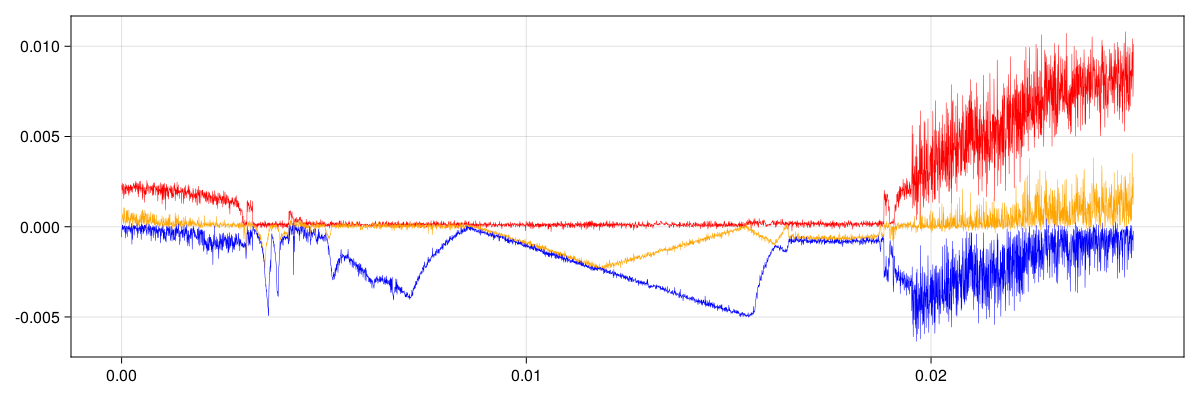

In [26]:
f = Figure(resolution = (1200, 400))
axis = Axis(f[1, 1])
lines!(axis, p_range, Λs[:, 1], color = :red, linewidth = 0.5)
lines!(axis, p_range, Λs[:, 2], color = :orange, linewidth = 0.5)
lines!(axis, p_range, Λs[:, 3], color = :blue, linewidth = 0.5)
f

In [27]:
save("LSE_electrical.jld", "data",Λs)
save("u0_electrical.jld", "data", u0s)